# 7: Ulysses' Compass
This chapter deals with model selection criteria and over/underfitting. There is an excellent discussion of out-of-sample model evaluation criteria (and original derivation of PSIS-LOO) in [this paper](https://arxiv.org/pdf/1507.04544.pdf).

In [111]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
%cd c:/msys64/home/ecotner/statistical-rethinking/

c:\msys64\home\ecotner\statistical-rethinking


In [889]:
import sys
sys.path.insert(0, r"c:\msys64\home\ecotner\statistical-rethinking\code")
from IPython.display import clear_output

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import tqdm
import networkx as nx

import torch
import torch.tensor as tt
import pyro
from pyro.nn import PyroModule
from pyro import poutine
from pyro.distributions import Normal, Uniform, Exponential, LogNormal

from models import RegressionBase
from utils import sample_posterior, precis, HPDI, plot_intervals, conditional_independencies, marginal_independencies

### Code 7.1 - 7.3
An example of overfitting

In [120]:
df = pd.DataFrame(dict(
    species = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"],
    brain = [438, 452, 612, 521, 752, 871, 1350],
    mass = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],
))
df["mass_std"] = (df["mass"] - df["mass"].mean())/df["mass"].std(ddof=0)
df["brain_std"] = (df["brain"] - df["brain"].mean())/df["brain"].std(ddof=0)

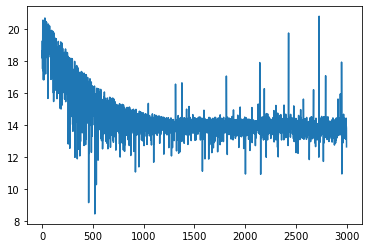

In [121]:
class M7_1(RegressionBase):
    def __call__(self, mass=None):
        a = pyro.sample("a", Normal(0.5, 1.))
        b = pyro.sample("b", Normal(0., 10.))
        sigma = pyro.sample("sigma", LogNormal(0., 1.))
        if mass is None:
            mu = pyro.deterministic("mu", a + b*self.mass_std)
            pyro.sample("brain_std", Normal(mu, sigma), obs=self.brain_std)
        else:
            mu = pyro.deterministic("mu", a + b*mass)
            return pyro.sample("brain_std", Normal(mu, sigma))
    
m7_1 = M7_1(df[["mass_std", "brain_std"]])
loss = m7_1.train(3000, lr=1e-3)
plt.plot(loss); plt.show()

### Code 7.4
This model has a non-Bayesian counterpart, which is Ordinary Least Squares (OLS). We can get a "posterior" for this model, although it treats `sigma` as a fixed (tunable) parameter

In [85]:
m, b, _, _, s = st.linregress(*df[["mass_std", "brain_std"]].values.T)

### Code 7.5 -7.6
Get the posterior samples, and show $R^2$ is a bad metric for success

                mean    stddev      5.5%     94.5%
a          0.0624374  0.299508 -0.401276  0.547801
b           0.678612  0.322628  0.133596      1.18
sigma       0.912785  0.234194  0.588379   1.32937
brain_std  0.0605739   1.25083  -1.89436   2.09378
mu         0.0624374  0.808893  -1.06746   1.43478


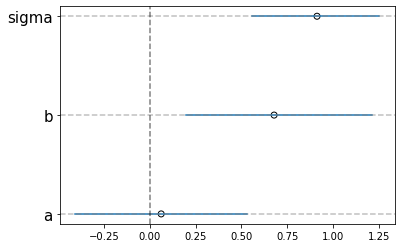

In [87]:
x = tt(df["mass_std"].values)
samples = sample_posterior(m7_1, 1000, ("a", "b", "sigma", "mu", "brain_std"), data=x)
print(precis(samples))
plot_intervals({k: samples[k] for k in ("a", "b", "sigma")}, 0.89)

In [88]:
r = samples["brain_std"].mean(axis=0) - df["brain_std"].values[None,:]
resid_var = np.var(r)
outcome_var = np.var(df["brain_std"])
print((outcome_var - resid_var)/outcome_var)

0.4895694081583345


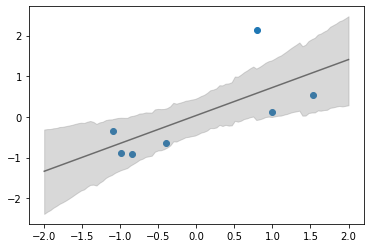

In [92]:
x = torch.linspace(-2, 2, 100)
samples = sample_posterior(m7_1, 1000, ("mu",), data=x)
mean = samples["mu"].mean(axis=0)
hpdi = np.array([HPDI(s, 0.89) for s in samples["mu"].T])
plt.scatter(df["mass_std"], df["brain_std"])
plt.plot(x, mean, color="black", alpha=0.5)
plt.fill_between(x, *hpdi.T, color="gray", alpha=0.3)
plt.show()

Seems to be a decent $R^2$ number and the fit is not bad.

In [101]:
# Make this into a function so that it can be evaluated quickly
def R2_is_bad(model):
    samples = sample_posterior(model, 1000, ("brain_std",), data=tt(df["mass_std"].values))
    r = samples["brain_std"].mean(axis=0) - df["brain_std"].values[None,:]
    return 1 - (np.var(r)/np.var(df["brain_std"]))
print(R2_is_bad(m7_1))

0.4886554043335988


### Code 7.7 - 7.10
Now we will consider a series of models which assume $\mu$ is a polynomial function of the standardized mass $m$, with increasing polynomial degree. I had some problems with using the `AutoMultivariateNormal` autoguide in `RegressionBase` because there are so many paramters it takes forever to display overfitting, so I'm just going to make a new model class using `AutoDiagonalNormal` because it requires less parameters.

In [17]:
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [18]:
class PolynomialRegression:
    def __init__(self, x, y, degree=1):
        self.degree = degree
        self.X = torch.stack([x**i for i in range(1, degree+1)]).T
        self.y = y
        
    def __call__(self, x=None):
        a = pyro.sample("a", Normal(0.5, 1.)).double()
        b = pyro.sample("b", Normal(0., 10.).expand([self.degree]).to_event(0)).double()
        if self.degree == 6:
            sigma = 0.001
        else:
            sigma = pyro.sample("sigma", LogNormal(0., 1.))
        if x is None:
            mu = pyro.deterministic("mu", a + torch.matmul(self.X, b))
            pyro.sample("brain_std", Normal(mu, sigma), obs=self.y)
        else:
            X = torch.stack([x**i for i in range(1, self.degree+1)])
            mu = pyro.deterministic("mu", a + torch.matmul(b, X))
            return pyro.sample("brain_std", Normal(mu, sigma))
        
    def train(self, num_steps):
        pyro.clear_param_store()
        self.guide = AutoDiagonalNormal(self)
        svi = SVI(
            model=self,
            guide=self.guide,
            optim=Adam({"lr": 1e-2}),
            loss=Trace_ELBO()
        )
        loss = []
        for _ in tqdm.notebook.trange(num_steps):
            loss.append(svi.step())
        return loss

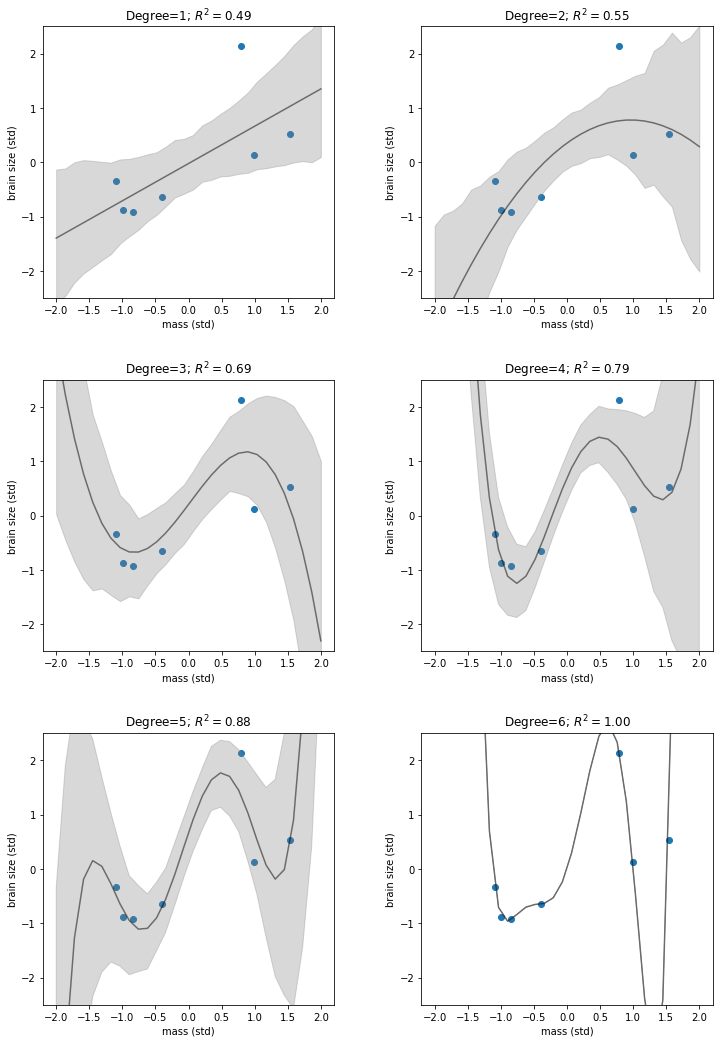

In [269]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12, 18))
losses = []
x = tt(df["mass_std"].values).double()
x_ = torch.linspace(-2, 2, 30).double()
y = tt(df["brain_std"].values).double()
for degree, ax in zip(range(1, 7), axes.flatten()):
    # Create/train model
    m7 = PolynomialRegression(x, y, degree)
    num_steps = int(round(1000 + (99_000./5)*(degree - 1)))
    losses.append(m7.train(num_steps))
    # Get samples/R^2 value
    samples = sample_posterior(m7, 1000, ("mu",), data=x_)
    R2 = R2_is_bad(m7)
    # Plot regression
    mean = samples["mu"].mean(axis=0)
    hpdi = np.array([HPDI(s, 0.89) for s in samples["mu"].T]).T
    plt.sca(ax)
    plt.scatter(df["mass_std"], df["brain_std"])
    plt.plot(x_, mean, color="black", alpha=0.5)
    plt.fill_between(x_, *hpdi, color="gray", alpha=0.3)
    plt.xlabel("mass (std)")
    plt.ylabel("brain size (std)")
    plt.title(f"Degree={degree}; "r"$R^2=$"f"{R2:.2f}")
    plt.ylim(bottom=-2.5, top=2.5)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
clear_output()
plt.show()

### Code 7.11
We can show that underfit models and overfit models are (in)sensitive to dropping various data points.

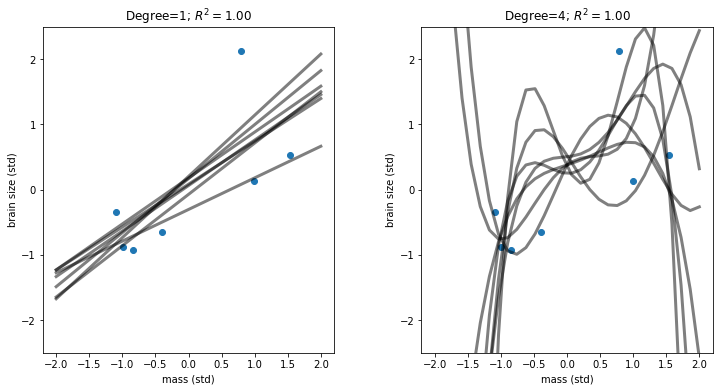

In [279]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
x = tt(df["mass_std"].values).double()
y = tt(df["brain_std"].values).double()
for degree, ax in zip((1, 4), axes.flatten()):
    plt.sca(ax)
    # Loop over removing data points one at a time
    for i in range(len(x)):
        x_ = tt([x[j] for j in range(len(x)) if j != i])
        y_ = tt([y[j] for j in range(len(y)) if j != i])
        # Create/train model
        m7 = PolynomialRegression(x_, y_, degree)
        losses.append(m7.train(3000))
        # Get samples
        x_ = torch.linspace(-2, 2, 30).double()
        samples = sample_posterior(m7, 1000, ("mu",), data=x_)
        # Plot regression
        mean = samples["mu"].mean(axis=0)
        plt.plot(x_, mean, color="black", alpha=0.5, linewidth=3)
    plt.scatter(df["mass_std"], df["brain_std"])
    plt.xlabel("mass (std)")
    plt.ylabel("brain size (std)")
    plt.title(f"Degree={degree}")
    plt.ylim(bottom=-2.5, top=2.5)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
clear_output()
plt.show()

### Code 7.12
Calculate the information entropy $H$ of the weather example where there is 0.3 probability of rain and 0.7 probability of sun. Information entropy of a (discrete) probability distribution $p$ is defined as
$$
H(p) = \sum_i p_i \log p_i
$$

In [282]:
p = np.array([0.3, 0.7])
print("H =", -(p*np.log(p)).sum())

H = 0.6108643020548935


### Code 7.13 - 7.14
It was shown that the optimal way to score models from a theoretical perspective is to use the KL divergence $D_{KL}(p,q) = \sum_i p_i \log(p_i/q_i)$, which is a measure of how much more uncertainty we suffer from using the distribution $q$ to approximate the "true" distribution $p$. Because we don't ever actually know what the "true" distribution $p$ is, we are only ever typically interested in the difference in information gain we get from using different models $q$ and $r$: 
$$D_{KL}(p,q) - D_{KL}(p,r) = \sum_i p_i \log(r_i/q_i) = \mathbb{E}_p\left[\log(r_i) - \log(q_i)\right]$$
This expectation can be approximated by $\frac{1}{N}\left[S(r) - S(p)\right]$, where $N$ is the number of observations, and $S(q) = \sum_{i=1}^N \log(q_i)$ is the "log-probability score".

The Bayesian version of the log-probability score is called the "log-pointwise-predictive-density", or "LPPD" for short. It is the log of the likelihood of the data, averaged over the posterior (i.e. first average the likelihood, then take the log)
$$
\begin{align}
LPPD &= \sum_{i=1}^N \log \left[\int d\theta\; p(x_i|\theta) p_\text{post}(\theta)\right] \\
&\approx \sum_{i=1}^N \log \left[\frac{1}{S} \sum_s p(x_i|\theta_s)\right]
\end{align}
$$
where $s$ indexes over samples from the posterior (and $S$ is the number of samples).

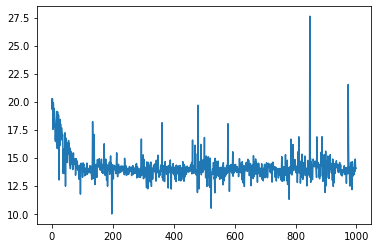

In [688]:
# Re-train model m7_1 and calculate the lppd
m7_1 = M7_1(df[["mass_std", "brain_std"]])
loss = m7_1.train(1000, lr=1e-2, autoguide="AutoMultivariateNormal")
plt.plot(loss); plt.show()

Because exponentiating things is potentially numerically unstable, we use a simple trick to make it stable:
$$
\begin{align}
logsumexp(x) &= \log \sum_i \exp(x_i) \\
&= \log \sum_i \exp(x_i) \exp(b) \exp(-b) \\
&= \log \left(\exp(b) \sum_i \exp(x_i-b)\right) \\
&= b + \log \sum_i \exp(x_i-b)
\end{align}
$$
which is valid for any value of $b$. If we use $b = \max(x)$, then we will never have a numerical overflow because $x_i - b < 0 \implies 0 < \exp(x_i - b) < 1$.

In [694]:
def LPPD(model, x, y, out_var_nm, num_samples=100):
    p = torch.zeros((num_samples, len(x)))
    for i in range(num_samples):
        tr = poutine.trace(poutine.condition(model, data=model.guide())).get_trace(x)
        p[i] = tr.nodes[out_var_nm]["fn"].log_prob(y).detach()
    pmax = p.max(axis=0).values
    lppd = pmax + (p - pmax).exp().mean(axis=0).log() # numerically stable version
    return lppd

x = tt(df["mass_std"].values)
y = tt(df["brain_std"].values)
lppd = LPPD(m7_1, x, y, "brain_std", 1000)
print(lppd)

tensor([-0.9898, -0.9586, -1.0482, -0.9842, -1.1076, -1.1345, -2.1641])


For some reason, the LPPD values that McElreath gets are a little different... probably just different normalizing constants? One thing to be aware of is that the actual value of any log likelihood doesn't really mean anything. It is only the difference between the LL of two different models that holds any logical importance. One easy way to see this is that the likelihood may have physical units (e.g. $\int dx\, p(x) = 1$ where $x$ is in meters implies $p$ has units of 1/meters), and it is completely nonsensical to take the log of a dimensionful quantity. But since $\log(a) - \log(b) = \log(a/b)$, if $a$ and $b$ are the same type of quantity, their dimensions cancel.

### Code 7.15
I don't want to re-train models `m7_1` - `m7_6` again, but the point of this section is just to show that the LPPD is still susceptible to the same kind of problem as $R^2$: the value generally becomes higher as a model overfits to the training set.

### Code 7.16 - 7.18
Reproduce the figure showing how the both the in-sample and out-of-sample deviance changes as you change the number of parameters of your model. We will take a simple "true" data generating process
$$
y_i \sim \text{Normal}(\mu_i, 1) \\
\mu_i = (0.15)x_{1,i} - (0.4)x_{2,i}
$$
and try and infer the values $\beta_1 = 0.15$ and $\beta_2 = -0.4$ using linear regression.

In [711]:
class Fig7_6(RegressionBase):
    def __init__(self, df, n_feat):
        super().__init__(df)
        self.n_feat = n_feat
        self.X = torch.stack([getattr(self, f"x{i}") for i in range(n_feat)])
    
    def __call__(self, X=None):
        beta = pyro.sample("beta", Normal(0., 1.).expand([self.n_feat]).to_event(0)).double()
        if X is None:
            mu = torch.matmul(beta, self.X)
            pyro.sample("y", Normal(mu, 1), obs=self.y)
        else:
            mu = torch.matmul(X, beta)
            pyro.sample("y", Normal(mu, 1))
            
def gen_data(n_feat, N):
    X = np.random.randn(N, max(n_feat, 2))
    mu = 0.15*X[:,0] - 0.4*X[:,1]
    y = np.random.randn(N) + mu
    return X[:,:n_feat], y
            
deviance = {
    n: {
        "in": {i: [] for i in range(1, 6)},
        "out": {i: [] for i in range(1, 6)},
    } for n in (20, 100)
}
num_simulations = 100
pbar = tqdm.notebook.tnrange(2*5*num_simulations)
for N in (20, 100):
    # Loop over number of features to use
    for n_feat in range(1, 6):
        # Loop over simulations
        for _ in range(num_simulations):
            # Generate training data
            X, y = gen_data(n_feat, N)
            X = np.concatenate([X, y[:,None]], axis=1)
            d = pd.DataFrame(X, columns=[f"x{i}" for i in range(n_feat)] + ["y"])
            # Train model
            model = Fig7_6(d, n_feat=n_feat)
            loss = model.train(1000, autoguide="AutoDiagonalNormal", use_tqdm=False)
            # Get in-sample deviance
            lppd = LPPD(model, model.X.T, tt(y), "y", 100).sum().item()
            deviance[N]["in"][n_feat].append(-2*lppd)
            # Get out-of-sample deviance
            X, y = gen_data(n_feat, N)
            lppd = LPPD(model, tt(X), tt(y), "y", 100).sum().item()
            deviance[N]["out"][n_feat].append(-2*lppd)
            pbar.update()
pbar.close()

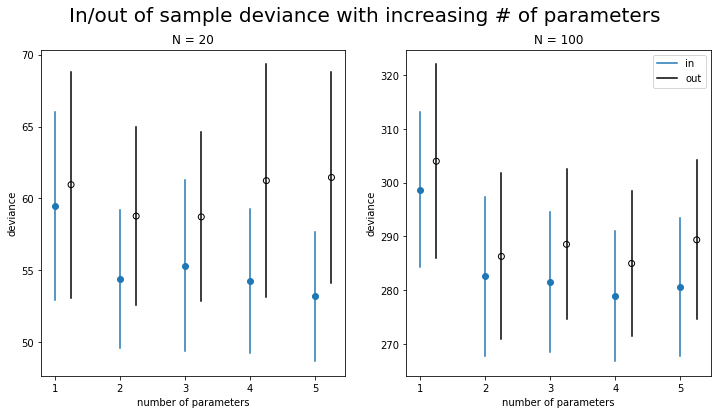

In [724]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

for (N, d1), ax in zip(deviance.items(), axes):
    plt.sca(ax)
    plt.xlabel("number of parameters")
    plt.ylabel("deviance")
    plt.title(f"N = {N}")
    for in_out, d2 in d1.items():
        options = dict(
            color = "C0" if (in_out == "in") else "black",
            edgecolor = "C0" if (in_out == "in") else "black",
            facecolor = "C0" if (in_out == "in") else "none",
        )
        offset = 0 if (in_out == "in") else 0.25
        for n_feat, sample in d2.items():
            mean = np.mean(sample)
            std = np.std(sample)
            plt.scatter([n_feat+offset], [mean], **options)
            x = 2*[n_feat + offset]
            y = [mean + std, mean - std]
            plt.plot(x, y, color=options["color"])
plt.plot([], [], color="C0", label="in")
plt.plot([], [], color="black", label="out")
fig.suptitle("In/out of sample deviance with increasing # of parameters", fontsize=20)
plt.legend()
plt.show()

Notice that the gap between in-sample and out-of-sample deviance is much smaller when you 1) have more data 2) use less parameters. One way to reduce this gap is to use _regularizing priors_, which have most of their probability mass concentrated around zero rather than spread out. This prevents your model from becoming overcomplicated.

### Code 7.19 - 7.24
Calculate WAIC (Widely Applicable Information Criterion) for a simple linear regression on the `cars` dataset. The WAIC for the $i$th datapoint is defined as
$$ \text{WAIC}_i = -2(lppd_i - \text{var}_\theta \log p(y_i|\theta))$$
The penalty term is also known as the "effective number of parameters", in anology with the penalty term in the AIC (which is literally the number of parameters in the model), but you should not think of it this way. Think of it as being indicative of how much the prediction of the model disagrees with the data.

In [734]:
cars_df = pd.read_csv("data/cars.csv", sep=",")[["speed", "dist"]]
cars_df.head()

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


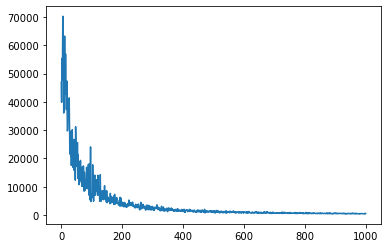

In [737]:
class Model(RegressionBase):
    def __call__(self, x=None):
        a = pyro.sample("a", Normal(0., 100.))
        b = pyro.sample("b", Normal(0., 10.))
        sigma = pyro.sample("sigma", Exponential(1.))
        if x is None:
            mu = a + b*self.speed
            pyro.sample("dist", Normal(mu, sigma), obs=self.dist)
        else:
            mu = a + b*x
            pyro.sample("dist", Normal(mu, sigma))
            
m = Model(cars_df)
loss = m.train(1000)
plt.plot(loss); plt.show()

In [814]:
def WAIC(model, x, y, out_var_nm, num_samples=100):
    p = torch.zeros((num_samples, len(y)))
    # Get log probability samples
    for i in range(num_samples):
        tr = poutine.trace(poutine.condition(model, data=model.guide())).get_trace(x)
        dist = tr.nodes[out_var_nm]["fn"]
        p[i] = dist.log_prob(y).detach()
    pmax = p.max(axis=0).values
    lppd = pmax + (p - pmax).exp().mean(axis=0).log() # numerically stable version
    penalty = p.var(axis=0)
    return -2*(lppd - penalty)

In [759]:
x = tt(cars_df["speed"].values).double()
y = tt(cars_df["dist"].values).double()
waic = WAIC(m, x, y, "dist", 1000)
print(f"WAIC = {waic.sum().item():.2f}")

WAIC = 1599.96


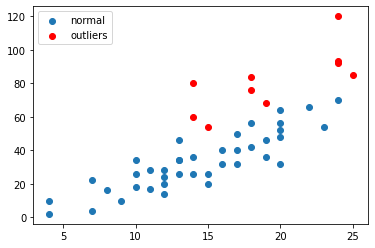

In [764]:
n_outliers = int(round(0.2*len(waic)))
idx = np.argsort(waic)[:-n_outliers]
plt.scatter(x[idx], y[idx], color="C0", label="normal")
idx = np.argsort(waic)[-n_outliers:]
plt.scatter(x[idx], y[idx], color="red", label="outliers")
plt.legend()
plt.show()

### Code 7.25 - 7.29
We're gonna go back and look at some old models from the previous chapter - the ones involving plant/fungus growth that were illustrative of confounding factors (m6_6, m6_7 and m6_8).

In [828]:
N = 100
h0 = 2*np.random.randn(N) + 10 # heights
treatment = np.random.choice((0, 1), N)
fungus = st.binom(n=1, p=(0.5-0.4*treatment)).rvs(N)
h1 = h0 + (5 - 3*fungus) + np.random.randn(N)
d = pd.DataFrame([h0, h1, treatment, fungus], index=["h0", "h1", "treatment", "fungus"]).T
d.head()

,h0,h1,treatment,fungus
0,9.378239,12.753071,0.0,1.0
1,8.329321,13.738196,0.0,0.0
2,12.780690,15.954807,1.0,0.0
3,7.664102,12.464290,1.0,0.0
4,10.407611,15.480364,1.0,0.0


In [865]:
class M6_7(RegressionBase):
    def __call__(self, x=None):
        a = pyro.sample("a", LogNormal(0., 0.25))
        bt = pyro.sample("bt", Normal(0., 0.5))
        bf = pyro.sample("bf", Normal(0, 0.5))
        sigma = pyro.sample("sigma", Exponential(1.))
        if x is None:
            p = pyro.deterministic("p", a + bt * self.treatment + bf * self.fungus)
            mu = pyro.deterministic("mu", self.h0 * p)
            pyro.sample("h1", Normal(mu, sigma), obs=self.h1)
        else:
            p = pyro.deterministic("p", a + bt * x["treatment"] + bf * x["fungus"])
            mu = pyro.deterministic("mu", x["h0"] * p)
            return pyro.sample("h1", Normal(mu, sigma))
            

m6_7 = M6_7(d, categoricals=["treatment", "fungus"])
m6_7.train(1000);

In [866]:
x = {
    "treatment": tt(d["treatment"]).double(),
    "fungus": tt(d["fungus"]).double(),
    "h0": tt(d["h0"]).double(),
}
y = tt(d["h1"]).double()
WAIC(m6_7, x, y, "h1", 1000).sum()

tensor(335.6316)

Now let's compute this for _all_ the models

In [867]:
waic = {"m6.7": WAIC(m6_7, x, y, "h1", 1000)}

In [868]:
class M6_6(RegressionBase):        
    def __call__(self, x=None):
        p = pyro.sample("p", LogNormal(0., 0.25))
        sigma = pyro.sample("sigma", Exponential(1.))
        if x is None:
            mu = pyro.deterministic("mu", self.h0 * p)
            pyro.sample("h1", Normal(mu, sigma), obs=self.h1)
        else:
            mu = pyro.deterministic("mu", x["h0"] * p)
            pyro.sample("h1", Normal(mu, sigma))
        
m6_6 = M6_6(d[["h1", "h0"]])
m6_6.train(1000);
waic["m6.6"] = WAIC(m6_6, x, y, "h1", 1000)

In [870]:
class M6_8(RegressionBase):
    def __call__(self, x=None):
        a = pyro.sample("a", LogNormal(0., 0.25))
        bt = pyro.sample("bt", Normal(0., 0.5))
        sigma = pyro.sample("sigma", Exponential(1.))
        if x is None:
            p = pyro.deterministic("p", a + bt * self.treatment)
            mu = pyro.deterministic("mu", self.h0 * p)
            pyro.sample("h1", Normal(mu, sigma), obs=self.h1)
        else:
            p = pyro.deterministic("p", a + bt * x["treatment"])
            mu = pyro.deterministic("mu", x["h0"] * p)
            pyro.sample("h1", Normal(mu, sigma))
        
m6_8 = M6_8(d, categoricals=["treatment", "fungus"])
m6_8.train(1000)
waic["m6.8"] = WAIC(m6_8, x, y, "h1", 1000)

Which one has the best expected out-of-sample predictive accuracy? Sort by total WAIC value:

In [877]:
waic_df = pd.DataFrame([
    (k, v.sum().item(), np.sqrt(len(y)*v.var().item()))
    for k, v in waic.items()
], columns=("model", "WAIC", "std_err"))
waic_df["diff"] = waic_df["WAIC"] - waic_df["WAIC"].min()
waic_df.sort_values("WAIC")

,model,WAIC,std_err,diff
0,m6.7,335.529999,12.535141,0.000000
2,m6.8,399.213196,10.814309,63.683197
1,m6.6,409.630585,9.601969,74.100586


We can see from comparing the standard error witht the difference in WAIC that model 6.7 is clearly the best (it is several multiples of `std_err` lower than the other models), but because the difference between the WAIC of models 6.7 and 6.8 is comparable to their standard error, the difference between these two is less clear. What we actually want to look at is the standard error of the pointwise difference in WAIC:

In [881]:
{k: np.sqrt(len(y)*(waic[k] - waic["m6.7"]).var().item()) for k in waic}

{'m6.7': 0.0, 'm6.6': 12.146899257799584, 'm6.8': 12.432525195754582}

### Code 7.32 - 7.??
We can also use information criterion as a means for identifying observations that the model has trouble with. Let us look at the primate dataset:

In [884]:
df = pd.read_csv("data/Primates301.csv", sep=";")
df.sample(5)

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
191,Microcebus_danfossi,Microcebus,danfossi,NaN,192,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,Macaca_arctoides,Macaca,arctoides,NaN,164,39,1.0,48.0,100.70,10300.0,NaN,176.60,377.66,360.0,1570.01,554.26
76,Cercopithecus_petaurista,Cercopithecus,petaurista,NaN,77,17,0.0,5.0,55.08,3609.0,14.0,NaN,NaN,228.0,NaN,NaN
156,Lepilemur_sahamalazensis,Lepilemur,sahamalazensis,NaN,157,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,Pithecia_pithecia,Pithecia,pithecia,NaN,246,53,0.0,28.0,32.26,1760.0,2.7,161.13,113.15,248.4,1089.37,274.28


Our intent is to see if there is a direct effect of brain size on longevity. Our causal DAG is given by

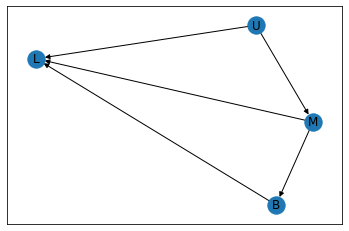

In [886]:
G = nx.DiGraph((("M", "B"), ("M", "L"), ("B", "L"), ("U", "M"), ("U", "L")))
nx.draw_networkx(G)

Where $M$ is body mass, $B$ is brain volume, $L$ is longevity, and $U$ is some unknown confounding factor. We can close off the backdoor $B \leftarrow M \rightarrow L$ by conditioning on $M$, but there is no way to control for $U$'s influence on $L$ without measuring $U$. Let's hope it doesn't have too much of an influence.

In [899]:
# Log-transform and standardize variables
for k1, k2 in (("log_L", "longevity"), ("log_B", "brain"), ("log_M", "body")):
    x = np.log(df[k2])
    df[k1] = (x - x.mean())/x.std()

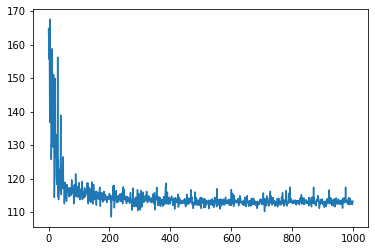

In [921]:
class M7_8(RegressionBase):
    def __call__(self, x=None):
        a = pyro.sample("a", Normal(0., 0.1))
        bB = pyro.sample("bB", Normal(0., 0.5))
        bM = pyro.sample("bM", Normal(0., 0.5))
        sigma = pyro.sample("sigma", Exponential(1.))
        if x is None:
            mu = a + bB * self.log_B + bM * self.log_M
            pyro.sample("log_L", Normal(mu, sigma), obs=self.log_L)
        else:
            mu = a + bB * x["log_B"] + bM * x["log_M"]
            return pyro.sample("log_L", Normal(mu, sigma))
        
d = df[["log_L", "log_M", "log_B"]]
d = d[~d.isna().any(axis=1)]
m7_8 = M7_8(d)
loss = m7_8.train(1000)
plt.plot(loss); plt.show()

In [923]:
x = {k: tt(list(v.values())) for k, v in d.to_dict().items()}
y = x["log_L"]
waic = {"m7.8": WAIC(m7_8, x, y, "log_L", 1000)}
samples = {"m7.8": sample_posterior(m7_8, num_samples=1000, sites=("bB", "bM"))}

We should also do two simpler models for comparison's sake

In [925]:
class SimplerModel(RegressionBase):
    def __init__(self, df, use):
        super().__init__(df)
        self.use = use
    
    def __call__(self, x=None):
        a = pyro.sample("a", Normal(0., 0.1))
        if self.use == "bB":
            bB = pyro.sample("bB", Normal(0., 0.5))
            bM = tt(0.).double()
        elif self.use == "bM":
            bM = pyro.sample("bM", Normal(0., 0.5))
            bB = tt(0.).double()
        sigma = pyro.sample("sigma", Exponential(1.))
        if x is None:
            mu = a + bB * self.log_B + bM * self.log_M
            pyro.sample("log_L", Normal(mu, sigma), obs=self.log_L)
        else:
            mu = a + bB * x["log_B"] + bM * x["log_M"]
            return pyro.sample("log_L", Normal(mu, sigma))

for name, var in (("m7.9", "bB"), ("m7.10", "bM")):
    m = SimplerModel(d, use=var)
    m.train(1000)
    waic[name] = WAIC(m, x, y, "log_L", 1000)
    samples[name] = sample_posterior(m, num_samples=1000, sites=("bB", "bM"))

In [926]:
waic_df = pd.DataFrame([
    (k, v.sum().item(), np.sqrt(len(y)*v.var().item()))
    for k, v in waic.items()
], columns=("model", "WAIC", "std_err"))
waic_df["diff"] = waic_df["WAIC"] - waic_df["WAIC"].min()
waic_df.sort_values("WAIC")

,model,WAIC,std_err,diff
1,m7.9,216.685440,14.348297,0.000000
0,m7.8,217.237579,13.917729,0.552139
2,m7.10,229.522873,15.114730,12.837433


In [927]:
# the standard error of the difference:
{k: np.sqrt(len(y)*(waic[k] - waic["m7.8"]).var().item()) for k in waic}

{'m7.8': 0.0, 'm7.9': 1.903411111481214, 'm7.10': 6.775074023021855}

It appears that after controlling for mass, brain volume has a strong positive influence on longevity. If using only mass (as in model 7.10), then it looks like _that_ has a strong positive influence on longevity.

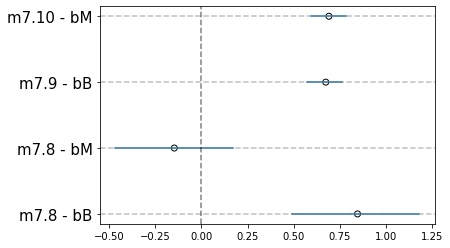

In [941]:
s = {f"{k1} - {k2}": v2 for k1, v1 in samples.items() for k2, v2 in v1.items()}
plot_intervals(s, 0.89)

The issue is that mass and brain size are correlated, so one might consider one a decent stand-in for the other.

In [940]:
np.corrcoef(x["log_M"], x["log_B"])

array([[1.        , 0.97962718],
       [0.97962718, 1.        ]])

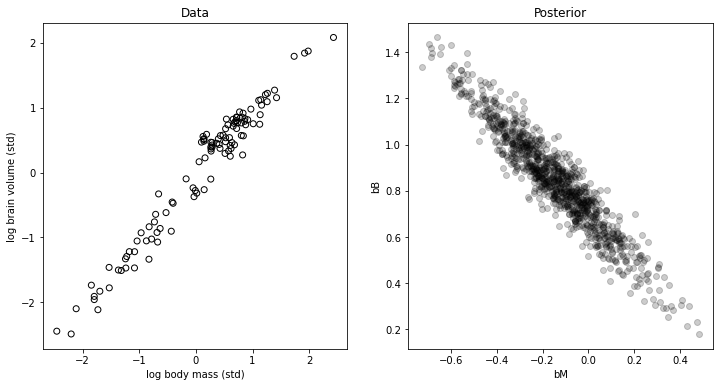

In [944]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
# plot mass-brain data
plt.sca(axes[0])
plt.scatter(x["log_M"], x["log_B"], edgecolor="black", facecolor="none")
plt.xlabel("log body mass (std)")
plt.ylabel("log brain volume (std)")
plt.title("Data")
# plot mass-brain coefficient posterior
plt.sca(axes[1])
s = samples["m7.8"]
plt.scatter(s["bM"], s["bB"], color="black", alpha=0.2)
plt.xlabel("bM")
plt.ylabel("bB")
plt.title("Posterior")
plt.show()

So now let's take a look and see which data point the WAIC thinks are difficult to model/predict.

In [949]:
df.iloc[d.index]

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment,log_L,log_B,log_M
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.0,40.00,NaN,106.15,276.0,NaN,NaN,-0.216108,0.372591,0.426012
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.0,8.90,185.92,323.16,243.6,1276.72,509.08,-0.511731,0.294526,0.515385
5,Alouatta_palliata,Alouatta,palliata,NaN,6,3,3.0,79.0,49.88,6250.0,13.10,185.42,495.60,300.0,1578.42,681.02,-0.018713,0.251558,0.607238
6,Alouatta_pigra,Alouatta,pigra,NaN,7,3,0.0,25.0,51.13,8915.0,5.50,185.92,NaN,240.0,NaN,NaN,-0.546978,0.271375,0.825686
8,Alouatta_seniculus,Alouatta,seniculus,NaN,9,3,0.0,82.0,55.22,5950.0,7.90,189.90,370.04,300.0,1690.22,559.94,-0.018713,0.332988,0.576982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,Theropithecus_gelada,Theropithecus,gelada,NaN,286,66,0.0,34.0,133.33,15350.0,10.00,178.64,494.95,336.0,1894.11,673.59,0.249579,1.038766,1.159907
287,Trachypithecus_cristatus,Trachypithecus,cristatus,NaN,288,67,0.0,8.0,57.86,6394.0,27.40,NaN,362.93,373.2,NaN,NaN,0.498162,0.370380,0.621249
294,Trachypithecus_obscurus,Trachypithecus,obscurus,NaN,295,67,0.0,6.0,62.12,7056.0,10.00,146.63,362.93,300.0,NaN,509.56,-0.018713,0.427259,0.681845
298,Trachypithecus_vetulus,Trachypithecus,vetulus,NaN,299,67,0.0,2.0,61.29,6237.0,8.35,204.72,245.78,276.0,1113.70,450.50,-0.216108,0.416490,0.605958


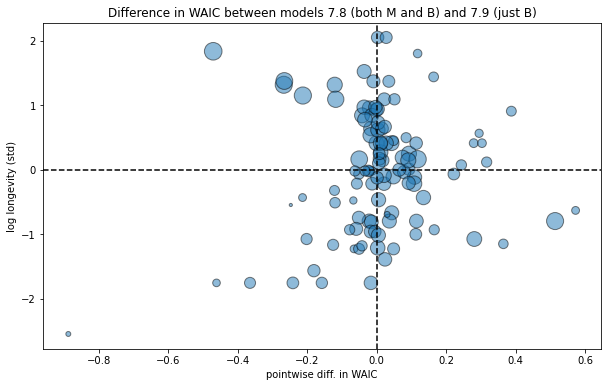

In [967]:
# Do some scaling so that primates with large brains
# and small mass have larger marker size
s = x["log_B"] - x["log_M"]
s = s - s.min()
s = 10 + 300*s/s.max()

# Draw plot
plt.figure(figsize=(10, 6))
plt.scatter(waic["m7.8"] - waic["m7.9"], x["log_L"], s=s, facecolor="C0", edgecolor="black", alpha=0.5)
plt.xlabel("pointwise diff. in WAIC")
plt.ylabel("log longevity (std)")
plt.axhline(0., color="black", linestyle="--")
plt.axvline(0., color="black", linestyle="--")
plt.title("Difference in WAIC between models 7.8 (both M and B) and 7.9 (just B)")
plt.show()

In [983]:
# Top 10 data points with the largest difference in WAIC
idx = (waic["m7.8"] - waic["m7.9"]).abs().argsort(descending=True)[:10].numpy()
df.iloc[idx]

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment,log_L,log_B,log_M
62,Cercopithecus_campbelli_lowei,Cercopithecus,campbelli,lowei,63,17,NaN,NaN,55.64,3187.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.339055,0.192982
37,Callicebus_personatus,Callicebus,personatus,NaN,38,12,0.0,19.0,NaN,1390.80,2.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.317041
13,Aotus_lemurinus,Aotus,lemurinus,NaN,14,4,0.0,16.0,16.30,734.00,NaN,132.23,74.57,216.0,755.15,206.80,-0.796406,-0.643938,-0.710153
20,Arctocebus_aureus,Arctocebus,aureus,NaN,21,6,NaN,NaN,5.88,210.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.460291,-1.479863
63,Cercopithecus_cephus,Cercopithecus,cephus,NaN,64,17,0.0,8.0,65.26,3585.00,11.00,169.51,362.93,276.0,1521.90,532.44,-0.216108,0.466741,0.265364
45,Callithrix_jacchus,Callithrix,jacchus,NaN,46,14,2.0,161.0,7.24,320.00,8.55,144.00,60.24,201.6,455.99,204.24,-0.959738,-1.293704,-1.220783
79,Cercopithecus_solatus,Cercopithecus,solatus,NaN,80,17,0.0,6.0,NaN,5256.91,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500806
55,Cercocebus_agilis,Cercocebus,agilis,NaN,56,16,NaN,NaN,116.43,7580.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.930248,0.725906
83,Cheirogaleus_medius,Cheirogaleus,medius,NaN,84,18,0.0,13.0,2.60,140.00,1.00,61.79,60.65,231.6,413.84,122.44,-0.631321,-2.113661,-1.729255
60,Cercopithecus_ascanius,Cercopithecus,ascanius,NaN,61,17,1.0,26.0,59.58,3714.00,26.30,148.50,146.54,339.6,1718.73,295.04,0.274809,0.393834,0.287107


### Code 7.44
What if the causal relationship between $B$ and $L$ is reversed (e.g. longer lives make it more worthwile to invest in larger brains)? Now if we condition on $B$ this opens up a backdoor path through the collider $M \rightarrow B \leftarrow L$.

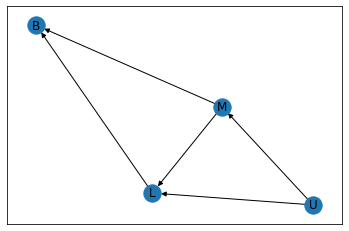

In [969]:
G = nx.DiGraph((("M", "B"), ("M", "L"), ("L", "B"), ("U", "M"), ("U", "L")))
nx.draw_networkx(G)

Perhaps in this case, it would be better to predict $B$, and instead condition on $M$ and $L$ to isolate their effects (this also has the double advantage of screening the effects of $U$).

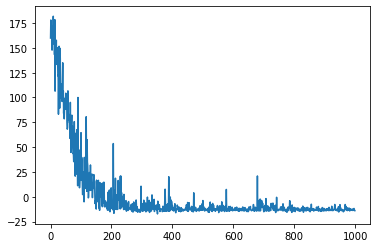

In [970]:
class M7_11(RegressionBase):
    def __call__(self, x=None):
        a = pyro.sample("a", Normal(0., 0.1))
        bL = pyro.sample("bL", Normal(0., 0.5))
        bM = pyro.sample("bM", Normal(0., 0.5))
        sigma = pyro.sample("sigma", Exponential(1.))
        if x is None:
            mu = a + bL * self.log_L + bM * self.log_M
            pyro.sample("log_B", Normal(mu, sigma), obs=self.log_B)
        else:
            mu = a + bL * x["log_L"] + bM * x["log_M"]
            return pyro.sample("log_B", Normal(mu, sigma))
        
d = df[["log_L", "log_M", "log_B"]]
d = d[~d.isna().any(axis=1)]
m7_11 = M7_11(d)
loss = m7_11.train(1000)
plt.plot(loss); plt.show()

In [972]:
samples = sample_posterior(m7_11, 1000, ("a", "sigma", "bL", "bM"))
precis(samples)

,mean,stddev,5.5%,94.5%
a,-0.0456989,0.0186104,-0.0757322,-0.0154388
bL,0.10661,0.0381517,0.050038,0.167283
bM,0.944134,0.0275972,0.902051,0.988368
sigma,0.194224,0.0144587,0.171926,0.217901


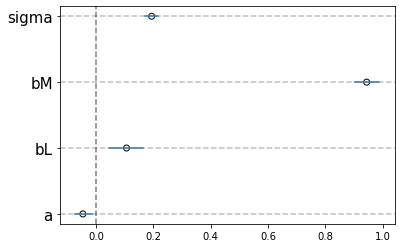

In [974]:
plot_intervals(samples, 0.89)

We can see that in this case, the model is much more confident about its predictions. Longevity has a small but definite impact on brain size, and body mass has a _very_ strong influence. Does this mean that this is the correct causal model? Maybe...